In [1]:
from mongo_wrapper.mongo_wrapper import MongoWrapper
import os
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import nltk
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from collections import Counter, defaultdict
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

True

In [2]:
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = "news_outlets"
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")

mongo_client = MongoWrapper(
    ip=MONGO_IP,
    port=MONGO_PORT,
    db=MONGO_DB,
    user=MONGO_USERNAME,
    password=MONGO_PASSWORD,
)

2025-05-20 20:50:01,388 WARNING Logger Mongo was configured with True console stream
2025-05-20 20:50:01,733 INFO Connected to news_outlets database on 206.81.16.39


In [3]:
mongo_client.get_all_collections()

['gnews_Colima',
 'gnews_Zacatecas',
 'mediacloud_Jalisco',
 'mediacloud_Tamaulipas',
 'gnews_Veracruz',
 'mediacloud_Hidalgo',
 'gnews_Quintana Roo',
 'mediacloud_Baja California Sur',
 'mediacloud_Tabasco',
 'mediacloud_Nayarit',
 'mediacloud_Guanajuato',
 'gnews_Sinaloa',
 'gnews_Michoacan',
 'mediacloud_Colima',
 'gnews_Jalisco',
 'gnews_Guerrero',
 'mediacloud_Veracruz',
 'gnews_Morelos',
 'gnews_Puebla',
 'mediacloud_Sinaloa',
 'mediacloud_Durango',
 'mediacloud_Sonora',
 'gnews_Tlaxcala',
 'gnews_Ciudad de México',
 'mediacloud_Quintana Roo',
 'mediacloud_Puebla',
 'mediacloud_Baja California',
 'mediacloud_Nuevo Leon',
 'gnews_Sonora',
 'mediacloud_desempleo',
 'mediacloud_Campeche',
 'mediacloud_Queretaro',
 'mediacloud_Tlaxcala',
 'gnews_Queretaro',
 'gnews_Oaxaca',
 'gnews_San Luis Potosi',
 'mediacloud_San Luis Potosi',
 'gnews_Yucatan',
 'gnews_Chiapas',
 'mediacloud_Coahuila',
 'mediacloud_Aguascalientes',
 'mediacloud_Oaxaca',
 'mediacloud_Ciudad de México',
 'gnews_Coah

In [4]:
states = [
    "Aguascalientes", "Baja California", "Baja California Sur", "Campeche", "Chiapas", "Chihuahua",
    "Coahuila", "Colima", "Durango", "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "Mexico",
    "Michoacan", "Morelos", "Nayarit", "Nuevo Leon", "Oaxaca", "Puebla", "Queretaro", "Quintana Roo",
    "San Luis Potosi", "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz",
    "Yucatan", "Zacatecas", "Ciudad de México"]

In [5]:
state_dfs = {}

for state in states:
    try:
        collection_name = f"mediacloud_{state}"
        data = mongo_client.get_collection_entries(collection_name)
        df = pd.DataFrame(data)
        df = df[df['content'].notna() & (df['content'].str.strip() != '')]
        state_dfs[state] = df
    except Exception as e:
        print(f"error with {state}: {e}")

In [6]:
lemm = spacy.load('es_core_news_md')

custom_stopwords = {
    'él', 'ella', 'ellos', 'ellas', 'le', 'la', 'lo', 'les', 'las', 'los', 'sino', 'querétaro', 
    'año', 'mes', 'día', 'tiempo', 'momento', 'semana', '2021', '2022', '2025', 'méxico',
    'mil', 'ciento', 'millón', 'dólares', 'tener', 'hacer', 'ver', 'ir', 'llegar', 'mexicano',
    'salir', 'seguir', 'entre', 'sobre', 'tras', 'mediante', 'durante', 'aunque', 'ciudad',
    'nacional', 'persona', 'caso', 'entidad', 'the', 'país', 'público', 'general', 'lópez',
    'gobierno', 'presidente', 'chihuahua', 'california', 'león', 'durango', 'coahuila', 'puebla', 
    'luis', 'san', 'roo', 'veracruz', 'aguascalientes', 'baja', 'sur', 'potosí', 'sinaloa',
    'campeche', 'chiapas', 'colima',  'estado', 'guanajuato', 'ciudad', 'estado', 'quintana',  
    'guerrero', 'hidalgo', 'jalisco', 'michoacán', 'morelos', 'nayarit', 'nuevo león', 
    'sonora', 'tabasco', 'tamaulipas', 'tlaxcala', 'yucatán', 'zacatecas', 'oaxaca'}

ALL_STOP_WORDS = STOP_WORDS.union(custom_stopwords)

def preprocess(text):
    # lowercase 
    text = text.lower()
    # process with spacy
    doc = lemm(text)
    tokens = [
        token.lemma_ for token in doc 
        if token.lemma_ not in ALL_STOP_WORDS                  # remove stop words (default and custom)
        and not token.is_punct                                 # remove punctuation
        and not token.is_digit                                 # remove numbers 
        and not any(char.isdigit() for char in token.text)     # remove tokens with digits (e.g., tokens with hyphen dividing numbers)
        and len(token.lemma_.strip()) > 2                      # remove short tokens
        and token.lemma_.strip() != '']                        # remove empty tokens
    return " ".join(tokens) 

In [7]:
state_dfs_cleaned = {}

for state, df in state_dfs.items():
    try:  
        # copy of the original dataframe
        df_cleaned = df.copy()
        # preprocess the content column
        df_cleaned['text_cleaned'] = df_cleaned['content'].astype(str).apply(preprocess)
        # count the number of words
        df_cleaned['word_count'] = df_cleaned['text_cleaned'].apply(lambda x: len(x.split()))
        # remove comments that are too short
        df_cleaned = df_cleaned[df_cleaned['word_count'] >= 10]
        # save in dictionary
        state_dfs_cleaned[state] = df_cleaned
        print(f"Completed {state}: {len(df_cleaned)} documents remaining")
    except Exception as e:
        print(f"Error with {state}: {e}")

Completed Aguascalientes: 1444 documents remaining
Completed Baja California: 2624 documents remaining
Completed Baja California Sur: 1431 documents remaining
Completed Campeche: 1230 documents remaining
Completed Chiapas: 1283 documents remaining
Completed Chihuahua: 1537 documents remaining
Completed Coahuila: 1366 documents remaining
Completed Colima: 2826 documents remaining
Completed Durango: 1280 documents remaining
Completed Guanajuato: 1342 documents remaining
Completed Guerrero: 1191 documents remaining
Completed Hidalgo: 2471 documents remaining
Completed Jalisco: 1193 documents remaining
Completed Mexico: 1698 documents remaining
Completed Michoacan: 1840 documents remaining
Completed Morelos: 1008 documents remaining
Completed Nayarit: 1253 documents remaining
Completed Nuevo Leon: 1578 documents remaining
Completed Oaxaca: 1311 documents remaining
Completed Puebla: 939 documents remaining
Completed Queretaro: 1136 documents remaining
Completed Quintana Roo: 1803 documents 

In [8]:
df_cleaned.head()

,_id,language,media_name,media_url,publish_date,title,url,content,text_cleaned,word_count
0,154a0df5e366da55ac8ef47d70e6b3d249a7768e83e079...,es,noticiasdequeretaro.com.mx,noticiasdequeretaro.com.mx,2023-10-13,"Eclipse solar anular 2023; Cuándo, dónde verlo...",https://noticiasdequeretaro.com.mx/2023/10/13/...,"Nacional\nEclipse solar anular 2023; Cuándo, d...",eclipse solar anular ver él precaución tomar p...,171
1,5e6d1f24dbbc3b50e5c1b655ed8d01962d420131cf2e92...,es,noticiasdequeretaro.com.mx,noticiasdequeretaro.com.mx,2023-03-06,Noticias de Querétaro,https://noticiasdequeretaro.com.mx/2023/03/06/...,El auto en el que viajaba se impactó contra co...,auto viajar impactar contención concreto carre...,129
2,24ccbf07eaff7f5cc75a972c103bdf4041155a48024a92...,es,noticiasdequeretaro.com.mx,noticiasdequeretaro.com.mx,2022-12-12,Sin afectación por sismo en Querétaro: Kuri,https://noticiasdequeretaro.com.mx/2022/12/12/...,Portada\nSin afectación por sismo en Querétaro...,portada afectación sismo kuri pingback mzplay ...,160
3,89bac4abf205f7e6c2cd3ad5951bc088075938d74dda13...,es,noticiasdequeretaro.com.mx,noticiasdequeretaro.com.mx,2023-11-01,Con la esperanza en un hilo,https://noticiasdequeretaro.com.mx/2023/11/01/...,Buscan a víctimas de Otis en Acapulco\nPor Sai...,buscar víctima otis acapulco said muñoz enviad...,289
4,efe9bc782affd11f9ce8db5205e3ec9abe9154637c06ed...,es,noticiasdequeretaro.com.mx,noticiasdequeretaro.com.mx,2023-03-17,Fuego acaba con camioneta,https://noticiasdequeretaro.com.mx/2023/03/17/...,El incendio ocurrió en inmediaciones del parqu...,incendio ocurrir inmediación parque industrial...,121


In [23]:
lda_results = {}

for state, df in state_dfs_cleaned.items():
    try:
        # use the cleaned text
        texts = df['text_cleaned']
        # countervectorize the text
        cv = CountVectorizer(ngram_range=(1, 3), lowercase=False, min_df=0.001, max_df=0.4, 
                             stop_words=list(ALL_STOP_WORDS), token_pattern=r'\b[a-záéíóúñü]{3,}\b')
        cv.fit(texts)
        vectorized_text = cv.transform(texts)
        # convert dtm to the format required by gensim
        dtm_sparse = csr_matrix(vectorized_text)
        # convert sparse matrix to gensim corpus
        corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
        # create gensim dictionary from sklearn CountVectorizer vocabulary
        vocabulary_gensim = {}
        for key, val in cv.vocabulary_.items():  
            vocabulary_gensim[val] = key
        dictionary = corpora.Dictionary()
        dictionary.id2token = vocabulary_gensim
        dictionary.token2id = cv.vocabulary_
        
        # lda model
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, passes=15, random_state=42, eta=0.01) 
        lda_results[state] = {
            "model": lda_model,
            "corpus": corpus,
            "dictionary": dictionary}
        print(f"LDA for {state} completed")
    except Exception as e:
        print(f"error for {state}: {e}")

LDA for Aguascalientes completed
LDA for Baja California completed
LDA for Baja California Sur completed
LDA for Campeche completed
LDA for Chiapas completed
LDA for Chihuahua completed
LDA for Coahuila completed
LDA for Colima completed
LDA for Durango completed
LDA for Guanajuato completed
LDA for Guerrero completed
LDA for Hidalgo completed
LDA for Jalisco completed
LDA for Mexico completed
LDA for Michoacan completed
LDA for Morelos completed
LDA for Nayarit completed
LDA for Nuevo Leon completed
LDA for Oaxaca completed
LDA for Puebla completed
LDA for Queretaro completed
LDA for Quintana Roo completed
LDA for San Luis Potosi completed
LDA for Sinaloa completed
LDA for Sonora completed
LDA for Tabasco completed
LDA for Tamaulipas completed
LDA for Tlaxcala completed
LDA for Veracruz completed
LDA for Yucatan completed
LDA for Zacatecas completed
LDA for Ciudad de México completed


In [10]:
def top_topics(state, num_topics=10, num_words=20):
    model = lda_results[state]["model"]
    print(f"\nTop {num_words} words per topic in {state}:")
    for topic_id in range(min(num_topics, model.num_topics)):
        topic_words = model.show_topic(topic_id, topn=num_words)
        words = [w for w, p in topic_words]
        probs = [p for w, p in topic_words]
        
        print(f"\nTopic {topic_id}:")
        for word, prob in topic_words:
            print(f"  {word}: {prob:.4f}")

states_to_analyze = ["Sinaloa", "Ciudad de México"]  
for state in states_to_analyze:
    if state in lda_results:
        top_topics(state, num_words=15)


Top 15 words per topic in Sinaloa:

Topic 0:
  banda: 0.0061
  metal: 0.0035
  álbum: 0.0024
  paul: 0.0023
  rock: 0.0020
  música: 0.0020
  tocar: 0.0017
  escuchar: 0.0016
  grabar: 0.0015
  disco: 0.0014
  canción: 0.0013
  concierto: 0.0013
  llamado: 0.0011
  publicar: 0.0011
  lugar: 0.0011

Topic 1:
  mazatlán: 0.0040
  gobernador: 0.0013
  zona: 0.0013
  turismo: 0.0012
  secretario: 0.0012
  grupo: 0.0012
  centro: 0.0012
  político: 0.0012
  turístico: 0.0012
  protección: 0.0011
  tema: 0.0011
  alto: 0.0011
  mayo: 0.0010
  desarrollo: 0.0010
  estatal: 0.0010

Topic 2:
  mayo: 0.0026
  arma: 0.0024
  federal: 0.0023
  seguridad: 0.0019
  culiacán: 0.0017
  rosas: 0.0016
  mazatlán: 0.0016
  penal: 0.0015
  protección: 0.0014
  policía: 0.0014
  secretaría: 0.0014
  mujer: 0.0014
  civil: 0.0012
  rápido furioso: 0.0012
  rápido: 0.0012

Topic 3:
  salud: 0.0014
  españa: 0.0014
  gobernador: 0.0013
  ordaz: 0.0013
  enero: 0.0012
  seguridad: 0.0012
  quirino: 0.0011
  m

In [24]:
def create_interactive_vis(state):
    model = lda_results[state]["model"]
    corpus = lda_results[state]["corpus"]
    dictionary = lda_results[state]["dictionary"]

    vis = pyLDAvis.gensim_models.prepare(
        model, 
        corpus, 
        dictionary,
        sort_topics=False)

    return pyLDAvis.display(vis)

create_interactive_vis("Sinaloa")


Distribution of dominat topics in Sinaloa:
Topic 0 (11.0%): banda, metal, álbum, paul, rock
Topic 1 (12.4%): mazatlán, gobernador, zona, turismo, secretario
Topic 2 (23.4%): mayo, arma, federal, seguridad, culiacán
Topic 3 (17.9%): salud, españa, gobernador, ordaz, enero
Topic 4 (18.0%): guzmán, enero, salud, culiacán, mazatlán
Topic 5 (17.2%): frío, temperatura, zona, norte, ambiente


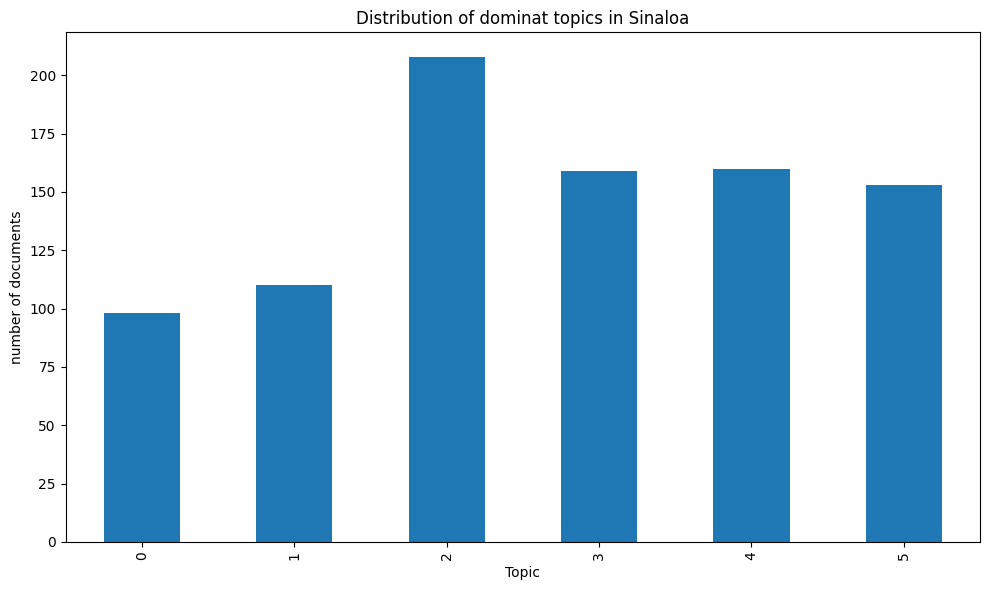


 examples of documents Sinaloa with dominant topic:

Topic 0 (banda, metal, álbum, paul, rock):
  probability : 1.0000
  document: cdmx.- portar uniforme reo color caqui camisa fajado pantalón zapato café bigote cabellera negro joaquín chapo guzmán loera centro federal readaptació...

Topic 1 (mazatlán, gobernador, zona, turismo, secretario):
  probability : 0.9997
  document: ingredion cimmyt aarc capacitan optimizar fertilizant cultivo maíz ciclo agrícola fertilizant aumentar precio temporada existir compromiso empresa ing...

Topic 2 (mayo, arma, federal, seguridad, culiacán):
  probability : 0.9998
  document: secretario función juez noveno distrito agua prieto sonoro vincular proceso lunes enero facundo rosas rosas comisionado policía federal hombre cercano...

Topic 3 (salud, españa, gobernador, ordaz, enero):
  probability : 0.9996
  document: alejandro moreno cárdenas comité ejecutivo cen partido revolucionario institucional pri adelantar lunes enero senador grupo parlamentari

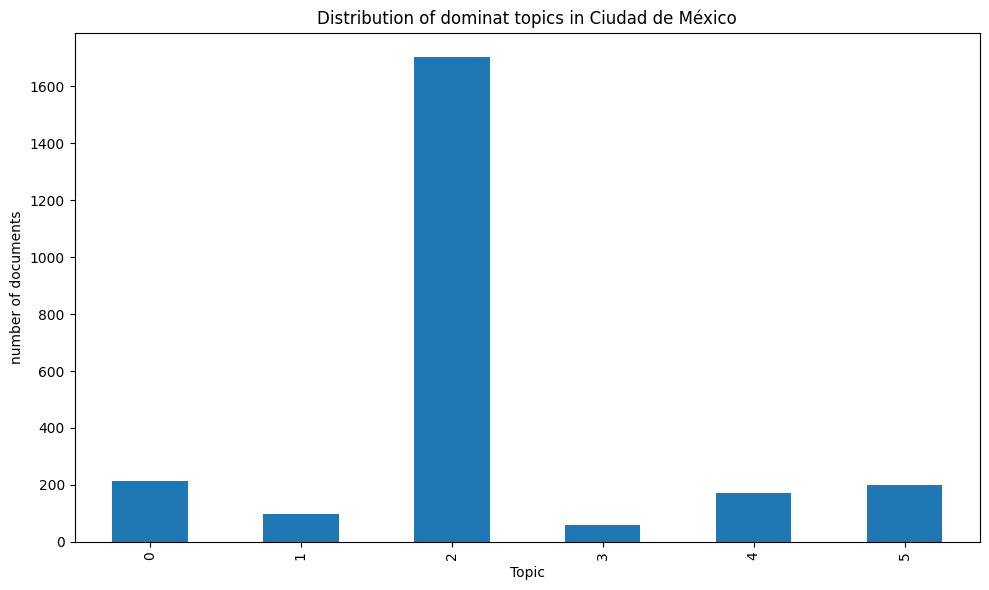


 examples of documents Ciudad de México with dominant topic:

Topic 0 (periodista, asesinato, violencia, mujer, humanos):
  probability : 0.9992
  document: alejandro encinas rodríguez titular subsecretaría derechos humanos población migración secretaría gobernación segob lamentar jueves enero periodista a...

Topic 1 (banda, metal, álbum, paul, rock):
  probability : 1.0000
  document: méxico.- joven sentir identificado política buscar participar activamente movimiento justicia social estudio organización internacional luminate améri...

Topic 2 (pesos, deber, enero, federal, social):
  probability : 0.9999
  document: josé artemio zúñiga mendoza juez control centro justicia penal federal reclusorio preventivo varonil norte determinar miércoles enero audiencia llevad...

Topic 3 (municipal, may, gas, juárez, precio):
  probability : 0.9985
  document: secretaría marina universidad naval informar abrir convocatoria ingreso establecimiento educativo naval período cerrar marzo plazo úni

In [12]:
def analyze_dominant_topics(state, num_docs=10):
    model = lda_results[state]["model"]
    corpus = lda_results[state]["corpus"]
    
    # get distribution of topics for each document
    doc_topics = [model[doc] for doc in corpus]
    
    # find the dominant topic for each document
    dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in doc_topics]
    dominant_probs = [max(topics, key=lambda x: x[1])[1] for topics in doc_topics]
    
    # df with results 
    df = pd.DataFrame({
        'Document': range(len(dominant_topics)),
        'Dominant_Topic': dominant_topics,
        'Topic_Probability': dominant_probs,
        'Text': state_dfs_cleaned[state]['text_cleaned'].values
    })
    
    # distrbution of dominant topics
    topic_distribution = df['Dominant_Topic'].value_counts().sort_index()
    print(f"\nDistribution of dominat topics in {state}:")
    for topic_id, count in topic_distribution.items():
        percentage = count / len(df) * 100
        topic_words = [word for word, _ in model.show_topic(int(topic_id), topn=5)]
        print(f"Topic {topic_id} ({percentage:.1f}%): {', '.join(topic_words)}")
    
    plt.figure(figsize=(10, 6))
    ax = topic_distribution.plot(kind='bar')
    ax.set_title(f'Distribution of dominat topics in {state}')
    ax.set_xlabel('Topic')
    ax.set_ylabel('number of documents')
    plt.tight_layout()
    plt.show()
    
    print(f"\n examples of documents {state} with dominant topic:")
    for topic_id in range(model.num_topics):
        docs_with_topic = df[df['Dominant_Topic'] == topic_id].sort_values(by='Topic_Probability', ascending=False)
        if not docs_with_topic.empty:
            doc_sample = docs_with_topic.iloc[0]
            
            text_preview = doc_sample['Text'][:150] + '...' if len(doc_sample['Text']) > 150 else doc_sample['Text']
            
            topic_words = [word for word, _ in model.show_topic(int(topic_id), topn=5)]
            print(f"\nTopic {topic_id} ({', '.join(topic_words)}):")
            print(f"  probability : {doc_sample['Topic_Probability']:.4f}")
            print(f"  document: {text_preview}")
    
    return df

for state in states_to_analyze:
    if state in lda_results:
        analyze_dominant_topics(state)

The u_mass coherence metric provides a way to evaluate how semantically meaningful the topics identified by LDA are. It works by examining whether the most important words in a topic tend to appear together in the same documents. Unlike some other coherence measures, u_mass only needs the processed corpus, not the original texts. It essentially asks: "When word A appears in a document, how likely is it that word B also appears?" The more often the top words of a topic co-occur in the same documents, the higher the coherence (closer to zero, as u_mass values are typically negative). For example, if a topic contains "music," "band," and "concert," u_mass checks how frequently these words appear together across documents. A value around -1 to -2 suggests good coherence, meaning the topic represents a genuine thematic pattern in the data rather than a random collection of words. Maximum u_mass coherence is 0, while it doesn't have a lower bound. 

Coherence (u_mass) for Aguascalientes: -1.2223
Coherence (u_mass) for Baja California: -1.1594
Coherence (u_mass) for Baja California Sur: -1.3600
Coherence (u_mass) for Campeche: -1.2135
Coherence (u_mass) for Chiapas: -1.1468
Coherence (u_mass) for Chihuahua: -0.2806
Coherence (u_mass) for Coahuila: -1.2777
Coherence (u_mass) for Colima: -1.2504
Coherence (u_mass) for Durango: -2.6348
Coherence (u_mass) for Guanajuato: -1.2801
Coherence (u_mass) for Guerrero: -1.3044
Coherence (u_mass) for Hidalgo: -1.3629
Coherence (u_mass) for Jalisco: -2.6283
Coherence (u_mass) for Mexico: -1.6053
Coherence (u_mass) for Michoacan: -1.9276
Coherence (u_mass) for Morelos: -2.3881
Coherence (u_mass) for Nayarit: -0.9677
Coherence (u_mass) for Nuevo Leon: -2.2315
Coherence (u_mass) for Oaxaca: -1.7286
Coherence (u_mass) for Puebla: -1.9201
Coherence (u_mass) for Queretaro: -2.5394
Coherence (u_mass) for Quintana Roo: -1.0079
Coherence (u_mass) for San Luis Potosi: -2.4179
Coherence (u_mass) for Sinalo

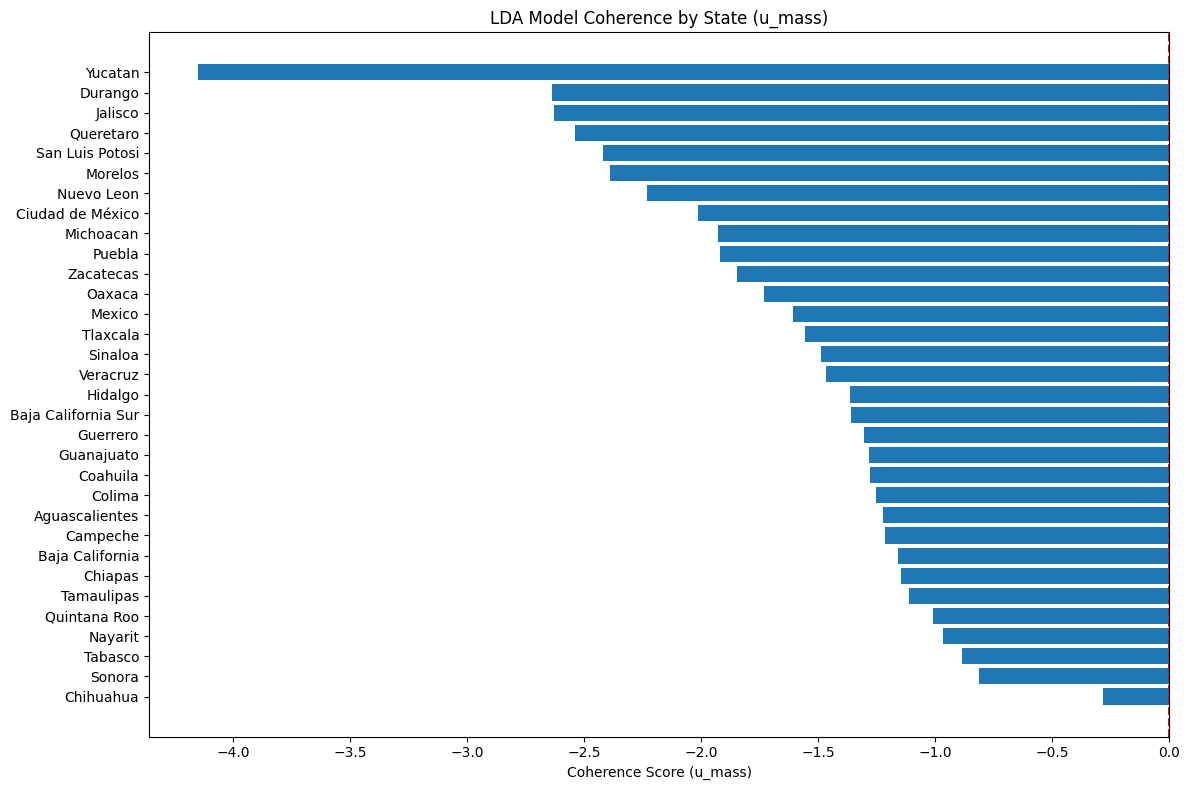

In [13]:
coherence_scores_umass = {}

for state in lda_results.keys():
    try:
        model = lda_results[state]["model"]
        corpus = lda_results[state]["corpus"]
        dictionary = lda_results[state]["dictionary"]
        
        coherence_model = CoherenceModel(
            model=model,
            corpus=corpus,
            dictionary=dictionary,
            coherence='u_mass'  
        )
        
        score = coherence_model.get_coherence()
        coherence_scores_umass[state] = score
        print(f"Coherence (u_mass) for {state}: {score:.4f}")
    
    except Exception as e:
        print(f"Error calculating coherence for {state}: {e}")


if coherence_scores_umass:
    sorted_coherence = sorted(coherence_scores_umass.items(), key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(12, 8))
    states, scores = zip(*sorted_coherence)
    plt.barh(states, scores)
    plt.xlabel('Coherence Score (u_mass)')
    plt.title('LDA Model Coherence by State (u_mass)')
    plt.axvline(x=0, color='r', linestyle='--') 
    plt.tight_layout()
    plt.show()

### Calculate topic shares 
 For each state the code retrieves the topic distribution that LDA has already assigned to each document(such as "Document 1 is 70% Topic 0, 20% Topic 2, and 10% Topic 5"). It then accumulates these probabilities for each topic across all documents in the state. For example, it adds up all the probabilities for Topic 0 from every document, does the same for Topic 1, and so on. Finally, it divides these sums by the total number of documents to get the average proportion of each topic. The result shows how prevalent each topic is within that state's media coverage. If Topic 3 has a share of 0.25, it means that, on average, 25% of the content across all documents in that state relates to Topic 3. 

In [14]:
# compute topic shares and save the csv

topic_shares = {}

for state, data in lda_results.items():
    model = data["model"]
    corpus = data["corpus"]
    
    topic_dist = np.zeros(model.num_topics)
    doc_count = 0
    for doc in corpus:
        doc_count += 1
        doc_topics = model[doc]
        for topic_id, prob in doc_topics:
            topic_dist[topic_id] += prob
    if doc_count > 0:
        topic_dist = topic_dist / doc_count
    topic_shares[state] = topic_dist

df_shares = pd.DataFrame.from_dict(topic_shares, orient='index')
df_shares.columns = [f'Topic_{i}' for i in range(df_shares.shape[1])]
df_shares.to_csv('topic_shares_eta_6.csv')

In [15]:
# save a csv that has the top words for each topic in each state - to identify the topics 

topic_keywords = {}

for state, data in lda_results.items():
    model = data["model"]

    state_topics = {}
    for topic_id in range(model.num_topics):
        top_words = model.show_topic(topic_id, topn=15)
        words = [word for word, _ in top_words]
        state_topics[f'Topic_{topic_id}'] = ', '.join(words)
    topic_keywords[state] = state_topics
df_keywords = pd.DataFrame.from_dict(topic_keywords, orient='index')

df_keywords.to_csv('topic_keywords_eta_6.csv')

In [16]:
df_keywords.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
Aguascalientes,"frío, norte, zona, racha, temperatura, ambient...","banda, metal, álbum, paul, rock, música, tocar...","electoral, partido, instituto, deber, pesos, m...","seguridad, policía, municipal, investigación, ...","federal, mayo, color, semáforo, salud, secreta...","equipo, investigador, descubrir, contagio, con..."
Baja California,"banda, metal, álbum, paul, rock, música, tocar...","frío, viento, temperatura, norte, zona, lluvia...","periodista, asesinato, enero, maldonado, lourd...","efectivo, remesa, estrategia, impulsar, descub...","pesos, precio, educación, clase, febrero, proc...","unidos, cabo, paz, autoridad, recibir, encontr..."
Baja California Sur,"frío, viento, temperatura, racha, norte, lluvi...","registrar, enero, tasa, pesos, precio, present...","banda, metal, álbum, paul, rock, música, tocar...","cabo, paz, vehículo, investigación, bcs, unida...","gobernador, federal, febrero, enero, secretarí...","paz, salud, cabo, periodista, municipio, nivel..."
Campeche,"salud, semáforo, contagio, secretaría, color, ...","frío, racha, lluvia, norte, zona, viento, ambi...","descubrir, investigador, metro, metro altura, ...","periodista, hijo, empresa, obrador, josé, bake...","banda, metal, álbum, paul, rock, música, tocar...","federal, gobernador, pesos, obrador, deber, po..."
Chiapas,"alto, paso, región, proteger, cártel, hijo, so...","frío, norte, racha, zona, temperatura, lluvia,...","periodista, migrant, enero, autoridad, federal...","pesos, trabajo, social, obrador, desarrollo, f...","elección, tuxtla, salud, electoral, riesgo, se...","banda, metal, álbum, paul, rock, música, tocar..."


In [17]:
vectorizer = CountVectorizer(ngram_range = (1,1))
topic0 = vectorizer.fit_transform(df_keywords['Topic_0'].astype(str))
dtm_0 = pd.DataFrame(topic0.toarray(), columns=vectorizer.get_feature_names_out())
word_sums_0 = dtm_0.sum(axis=0)
sorted_words_0 = word_sums_0.sort_values(ascending=False)
top30_0 = sorted_words_0.head(30)
print(top30_0)

álbum         9
música        9
concierto     9
disco         9
escuchar      9
grabar        9
banda         9
metal         9
lugar         9
paul          9
rock          9
tocar         9
canción       9
publicar      8
llamado       8
federal       7
salud         7
gobernador    6
enero         6
secretaría    6
local         5
ordoñez       4
municipal     4
seguridad     4
estatal       4
humanos       4
lourdes       4
diputado      4
unidos        4
mujer         4
dtype: int64


In [18]:
vectorizer = CountVectorizer(ngram_range = (1,1))
topic1 = vectorizer.fit_transform(df_keywords['Topic_1'].astype(str))
dtm_1 = pd.DataFrame(topic1.toarray(), columns=vectorizer.get_feature_names_out())
word_sums_1 = dtm_1.sum(axis=0)
sorted_words_1 = word_sums_1.sort_values(ascending=False)
top30_1 = sorted_words_1.head(30)
print(top30_1)

zona           9
social         9
mayo           9
estatal        9
salud          8
temperatura    8
seguridad      8
viento         7
frío           7
encontrar      7
mujer          7
lluvia         7
álbum          6
lugar          6
racha          6
norte          6
redacción      6
criterio       6
sonoro         6
ambiente       6
banda          5
grado          5
gobernador     5
grabar         5
música         5
paul           5
pesos          5
municipio      5
concierto      5
municipal      5
dtype: int64


In [19]:
vectorizer = CountVectorizer(ngram_range = (1,1))
topic2 = vectorizer.fit_transform(df_keywords['Topic_2'].astype(str))
dtm_2 = pd.DataFrame(topic2.toarray(), columns=vectorizer.get_feature_names_out())
word_sums_2 = dtm_2.sum(axis=0)
sorted_words_2 = word_sums_2.sort_values(ascending=False)
top30_2 = sorted_words_2.head(30)
print(top30_2)

lugar         10
federal        9
banda          9
rock           8
grabar         8
concierto      8
tocar          8
publicar       8
escuchar       8
canción        8
seguridad      8
paul           8
metal          8
álbum          8
música         8
disco          8
enero          7
estatal        7
secretaría     7
derechos       6
grupo          6
tip            6
llamado        6
mujer          6
salud          6
humanos        6
periodista     5
encontrar      5
zona           4
social         4
dtype: int64


In [20]:
vectorizer = CountVectorizer(ngram_range = (1,1))
topic3 = vectorizer.fit_transform(df_keywords['Topic_3'].astype(str))
dtm_3 = pd.DataFrame(topic3.toarray(), columns=vectorizer.get_feature_names_out())
word_sums_3 = dtm_3.sum(axis=0)
sorted_words_3 = word_sums_3.sort_values(ascending=False)
top30_3 = sorted_words_3.head(30)
print(top30_3)

seguridad     10
salud         10
federal       10
social         9
municipio      8
secretaría     8
lugar          7
estatal        7
pesos          7
gobernador     7
obrador        6
josé           5
encontrar      5
enero          5
grado          4
zona           4
descubrir      4
tamaulipa      4
alto           4
trabajo        4
programa       4
manuel         4
grupo          4
periodista     4
partido        4
informar       4
llamado        3
desarrollo     3
municipal      3
mujer          3
dtype: int64


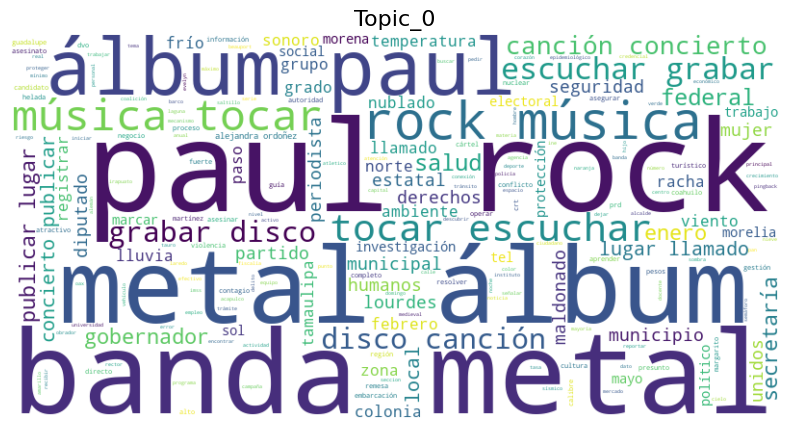

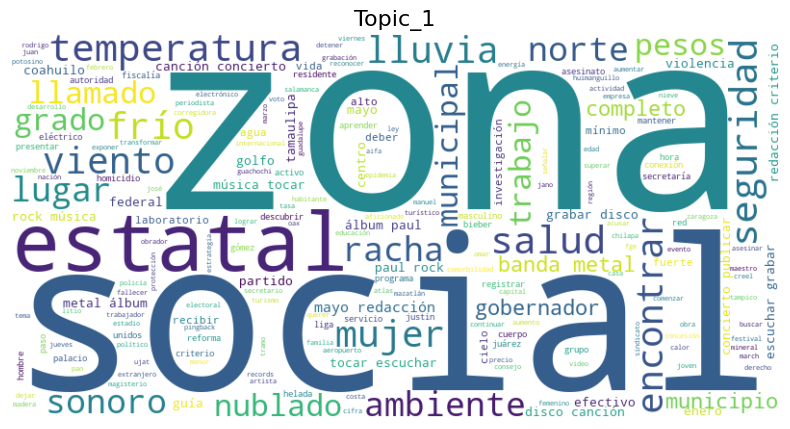

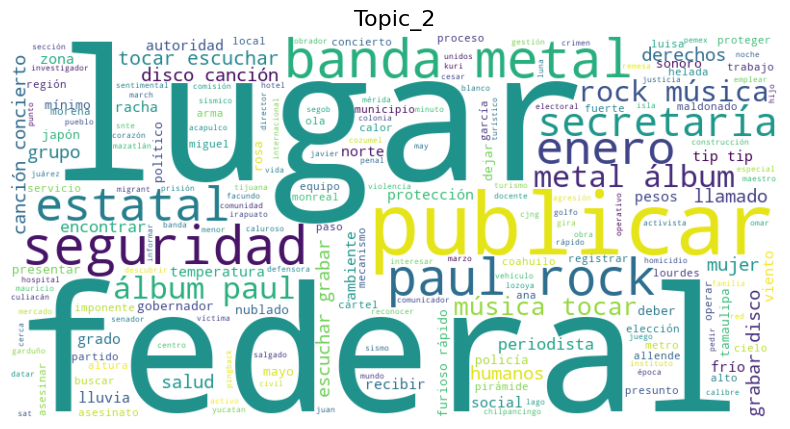

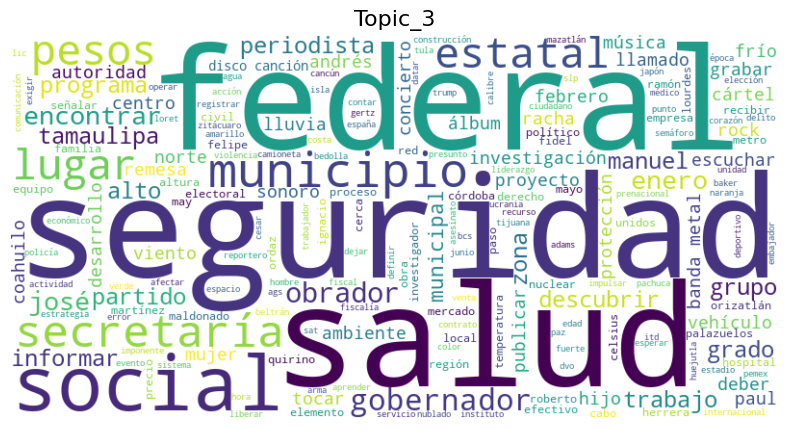

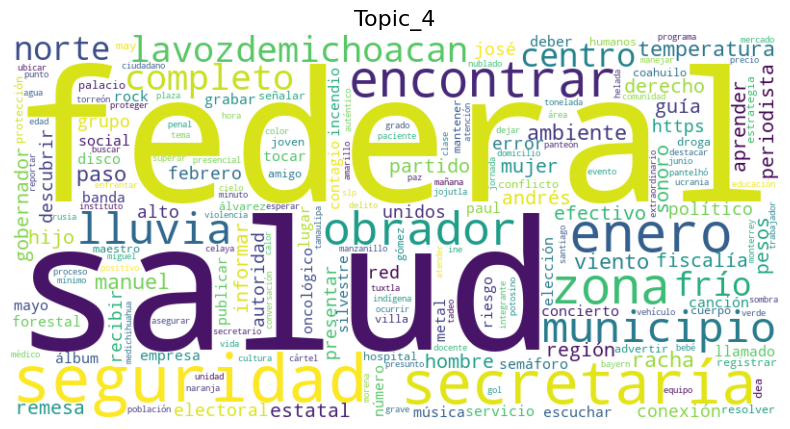

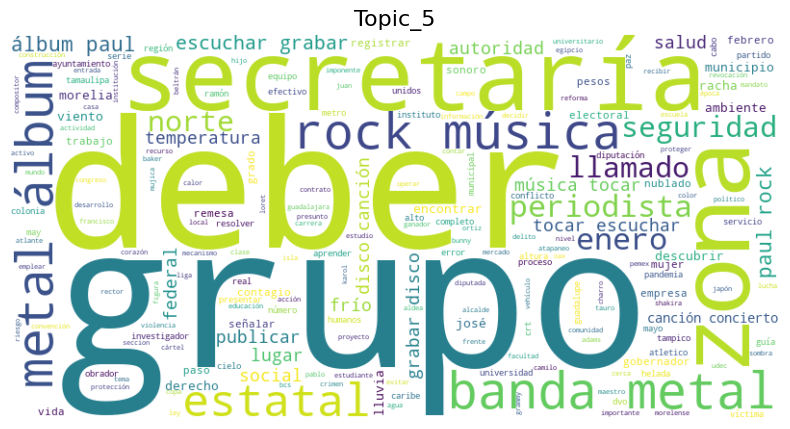

In [21]:
for col in df_keywords.columns:
    if col.startswith("Topic_"):
        text = ' '.join(df_keywords[col].dropna().tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(col, fontsize=16)
        plt.show()

In [22]:
topic_cols = [col for col in df_keywords.columns if col.startswith("Topic_")]
def generate_wordcloud(text):
    return WordCloud(width=800, height=400, background_color='white', colormap='viridis', random_state=42).generate(text)

for i in range(0, len(topic_cols), 4):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Wordclouds {i+1}–{min(i+4, len(topic_cols))}", fontsize=18)
    
    for j, ax in enumerate(axes.flat):
        if i + j < len(topic_cols):
            col = topic_cols[i + j]
            text = ' '.join(df_keywords[col].dropna().tolist())
            wordcloud = generate_wordcloud(text)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(col, fontsize=14)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"wordcloud_group_{i//4 + 1}.png", dpi=300)
    plt.close()